In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# Functions to build the hamiltonians

In [2]:
sx = sp.csr_matrix([[0,1],[1,0]], dtype=complex)
sy = sp.csr_matrix([[0,-1j],[1j,0]], dtype=complex)
sz = sp.csr_matrix([[1,0],[0,-1]], dtype=complex)
Iq = sp.eye(2, format='csr', dtype=complex)

def boson_ops(Nmax):
    dim = Nmax + 1
    # 'a' has sqrt(n) on the upper diagonal
    data = np.sqrt(np.arange(1, dim))
    a = sp.diags(data, 1, shape=(dim, dim), dtype=complex).tocsr()
    ad = a.conj().T
    nb = (ad @ a).tocsr()
    Ib = sp.eye(dim, format='csr', dtype=complex)
    return a, ad, nb, Ib

def cell_ops(Nmax):
    a, ad, nb, Ib = boson_ops(Nmax)
    A  = sp.kron(a , Iq, format='csr')
    Ad = sp.kron(ad, Iq, format='csr')
    Nb = sp.kron(nb, Iq, format='csr')
    Xb = A + Ad
    Yb = Ad - A
    Sx = sp.kron(Ib, sx, format='csr')
    Sy = sp.kron(Ib, sy, format='csr')
    Sz = sp.kron(Ib, sz, format='csr')
    Sp = 0.5 * (Sx + 1j * Sy)  
    Sm = 0.5 * (Sx - 1j * Sy)  
    I  = sp.kron(Ib, Iq, format='csr')
    return dict(A=A, Ad=Ad, Nb=Nb, Xb=Xb, Yb=Yb, Sx=Sx, Sy=Sy, Sz=Sz, Sp=Sp, Sm=Sm, I=I)

# ----- embedding helpers on the chain of L cells -----
def embed_one(op, site, L, d):
    I = sp.eye(d, format='csr', dtype=complex)
    mats = [I]*L
    mats[site] = op
    out = mats[0]
    for M in mats[1:]:
        out = sp.kron(out, M, format='csr')
    return out

def embed_two(opL, siteL, opR, siteR, L, d):
    assert siteL != siteR
    lo, hi = sorted((siteL, siteR))
    I = sp.eye(d, format='csr', dtype=complex)
    mats = [I]*L
    mats[siteL] = opL
    mats[siteR] = opR
    out = mats[0]
    for M in mats[1:]:
        out = sp.kron(out, M, format='csr')
    return out


# ----- full many-body Hamiltonian (open boundaries) -----
def build_H_full(L, omega_q, omega_c, g_phi, g_q, g_c, Nmax):
    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    H = sp.csr_matrix((d**L, d**L), dtype=complex)

    # on-site terms
    for n in range(L):
        H += (omega_q/2) * embed_one(ops['Sz'], n, L, d)
        H +=  omega_c    * embed_one(ops['Nb'], n, L, d)
        H +=  g_phi      * embed_one(ops['Sx'] @ ops['Xb'], n, L, d)  # σ^x ⊗ (a†+a)
   
    # inter-cell terms
    g_qc = np.sqrt(g_q * g_c)
    for n in range(L-1):
        H += -g_q * embed_two(ops['Sy'], n, ops['Sy'], n+1, L, d)
        H += -g_c * embed_two(ops['Yb'], n, ops['Yb'], n+1, L, d)
        H += 1j * g_qc * (
             - embed_two(ops['Sy'], n, ops['Yb'], n+1, L, d)
             + embed_two(ops['Yb'], n, ops['Sy'], n+1, L, d)
        )


    return H

def build_H_driven(L, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, Nmax,
                   boundary="open", theta_twist=0.0, return_J=False):
    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    H = sp.csr_matrix((d**L, d**L), dtype=complex)

    # on-site
    for n in range(L):
        H += (Δ_q/2) * embed_one(ops['Sz'], n, L, d)
        H += (Ω_d/2) * embed_one(ops['Sx'], n, L, d)
        H +=  Δ_c     * embed_one(ops['Nb'], n, L, d)
        H +=  g_phi   * embed_one(ops['Sp'] @ ops['A'] , n, L, d)
        H +=  g_phi   * embed_one(ops['Sm'] @ ops['Ad'], n, L, d)

    g_qc = np.sqrt(g_q * g_c)

    def bond_matrix(i, j, phase):
        return (
            - g_q  * phase * embed_two(ops['Sm'], i, ops['Sp'], j, L, d)
            + g_c  * phase * embed_two(ops['A'] , i, ops['Ad'], j, L, d)
            - g_qc * phase * embed_two(ops['Sm'], i, ops['Ad'], j, L, d)
            + g_qc * phase * embed_two(ops['A'] , i, ops['Sp'], j, L, d)
            )

    # accumulate inter-cell terms
    H_inter = sp.csr_matrix((d**L, d**L), dtype=complex)
    per_bond_phase = np.exp(1j * δΦ)
    for n in range(L-1):
        H_inter += bond_matrix(n, n+1, per_bond_phase)

    N_bonds = L-1
    # boundary bond
    if boundary in ("periodic", "twisted"):
        extra = theta_twist if boundary == "twisted" else 0.0
        H_inter += bond_matrix(L-1, 0, np.exp(1j * (δΦ + extra)))
        N_bonds=L

    # add Hermitian conjugate
    H += H_inter + H_inter.getH()
    
    if return_J:
        Jop = (1j / N_bonds) * (H_inter - H_inter.getH())
        return H, Jop
    else:
        return H



# Functions to compute the mean field order parameters numerically

In [3]:
def K_of_delta_phi(Delta_c, g_c, g_q, g_phi, delta_phi):
    """
    K(δφ) = 2 g_q cos δφ + (g_phi^2 + 4 g_q g_c sin^2 δφ) / (Delta_c + 2 g_c cos δφ)
    """
    A = Delta_c + 2.0 * g_c * np.cos(delta_phi)
    num = g_phi**2 + 4.0 * g_q * g_c * np.sin(delta_phi)**2
    return 2.0 * g_q * np.cos(delta_phi) + num / A

def dK_d_delta_phi(Delta_c, g_c, g_q, g_phi, delta_phi):
    """
    ∂K/∂δφ = -2 g_q sin δφ + d/dδφ [ (N/A) ] with
      N = g_phi^2 + 4 g_q g_c sin^2 δφ,  A = Delta_c + 2 g_c cos δφ
    """
    s, c = np.sin(delta_phi), np.cos(delta_phi)
    N  = g_phi**2 + 4.0 * g_q * g_c * (s**2)
    dN = 8.0 * g_q * g_c * s * c                # derivative of N
    A  = Delta_c + 2.0 * g_c * c
    dA = -2.0 * g_c * s
    return -2.0 * g_q * s + (dN * A - N * dA) / (A**2)

def mf_energy_theta(theta, Delta_q, Omega_d, K):
    """
    E(θ) = (Δ_q/2) cosθ - (Ω_d/2) sinθ - (K/4) sin^2θ   (with optimal φ=π if Ω_d>0)
    """
    s, c = np.sin(theta), np.cos(theta)
    return 0.5*Delta_q*c - 0.5*Omega_d*s - 0.25*K*(s**2)

def solve_theta(Delta_q, Omega_d, K, grid_points=4001):
    """
    1D minimization over θ ∈ [0, π] by dense sampling (robust & dependency-free).
    Returns θ* that minimizes E(θ).
    """
    thetas = np.linspace(0.0, np.pi, grid_points)
    Evals = mf_energy_theta(thetas, Delta_q, Omega_d, K)
    idx = int(np.argmin(Evals))
    return float(thetas[idx]), float(Evals[idx])

def mf_order_params(Delta_q, Delta_c, g_phi, g_q, g_c, Omega_d, delta_phi,
                    return_current=True):
    """
    Mean-field solution for uniform product state.
    Returns dict with: s, alpha, m, theta, phi, K, Emin, (optional) J.
    """
    # coupling renormalization from the chain
    K = K_of_delta_phi(Delta_c, g_c, g_q, g_phi, delta_phi)

    # minimize over θ (φ chosen to minimize drive term)
    phi = np.pi if Omega_d >= 0 else 0.0
    theta, Emin = solve_theta(Delta_q, Omega_d, K)

    # order parameters
    s = 0.5 * np.sin(theta) * np.exp(-1j * phi)    # <σ⁻>
    m = float(np.cos(theta))                        # <σᶻ>

    # coherent field (original rotating frame)
    A = Delta_c + 2.0 * g_c * np.cos(delta_phi)
    B = g_phi + 2j * np.sqrt(g_q * g_c) * np.sin(delta_phi)
    alpha = -(B / A) * s                            # <a>

    out = dict(s=s, alpha=alpha, m=m, theta=float(theta), phi=float(phi),
               K=float(K), Emin=float(Emin))

    if return_current:
        dK = dK_d_delta_phi(Delta_c, g_c, g_q, g_phi, delta_phi)
        J = 0.25 * (np.sin(theta)**2) * dK          # Hellmann–Feynman
        out["J"] = float(J.real)                    # current is real
    return out



# Functions for time evolution

In [4]:
# ----- initial states -----
def local_state(Nmax, boson='vac', spin='down', alpha=0.0):
    # boson |n=0> or |1> etc., or coherent
    dim = Nmax + 1
    if boson == 'vac':
        b = np.zeros(dim); b[0] = 1.0
    elif isinstance(boson, int):
        b = np.zeros(dim); 
        if boson > Nmax: raise ValueError("boson Fock > Nmax")
        b[boson] = 1.0
    elif boson == 'coh':
        n = np.arange(dim)
        b = np.exp(-0.5*abs(alpha)**2) * (alpha**n) / np.sqrt(sp.special.factorial(n).A.ravel() if isinstance(sp.special.factorial(n), sp.csr_matrix) else np.array([np.math.factorial(k) for k in n]))
        b = b / np.linalg.norm(b)
    else:
        raise ValueError("boson must be 'vac', int, or 'coh'")
    s = np.array([1,0]) if spin == 'down' else np.array([0,1])
    return np.kron(b, s).astype(complex)

def product_state(L, Nmax, left_excitation=('boson',1)):
    vloc = [local_state(Nmax, boson='vac', spin='down')]
    vecs = []
    for i in range(L):
        if i == 0:
            if left_excitation[0] == 'boson':
                vecs.append(local_state(Nmax, boson=left_excitation[1], spin='down'))
            elif left_excitation[0] == 'spin':
                vecs.append(local_state(Nmax, boson='vac', spin='up'))
            else:
                vecs.append(local_state(Nmax, boson='vac', spin='down'))
        else:
            vecs.append(local_state(Nmax, boson='vac', spin='down'))
    psi = vecs[0]
    for v in vecs[1:]:
        psi = np.kron(psi, v)
    return psi
# ----- time evolution via Krylov action -----
def evolve(H, psi0, t_array):
    A = (-1j) * H  # generator for expm_multiply (exp(t*A))
    t0, t1 = float(t_array[0]), float(t_array[-1])
    Y = spla.expm_multiply(A, psi0, start=t0, stop=t1, num=len(t_array), endpoint=True)
    return np.asarray(Y)  # shape (T, D)

# ----- measurements -----
def measure_local_ops(L, Nmax, states):
    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    # pre-embed once
    Nb_ops = [embed_one(ops['Nb'], i, L, d) for i in range(L)]
    Sz_ops = [embed_one(ops['Sz'], i, L, d) for i in range(L)]
    T = states.shape[0]
    nb = np.zeros((T, L), dtype=float)
    sz = np.zeros((T, L), dtype=float)
    for t in range(T):
        psi = states[t]
        for i in range(L):
            nb[t, i] = np.real(np.vdot(psi, Nb_ops[i] @ psi))
            sz[t, i] = np.real(np.vdot(psi, Sz_ops[i] @ psi))
    # edge probability proxy over first 2–3 cells
    P_edge = nb[:, :3].sum(axis=1) + 0.5 * (1 - sz[:, :3]).sum(axis=1)
    return nb, sz, P_edge


def vacuum_state(L, Nmax):
    dim_b = Nmax + 1
    b0 = np.zeros(dim_b); b0[0] = 1.0
    s_g = np.array([0.0, 1.0])   # <-- ground is σz=-1
    v_cell = np.kron(b0, s_g).astype(complex)
    psi = v_cell
    for _ in range(L-1):
        psi = np.kron(psi, v_cell)
    return psi

# --- build single-excitation edge state from profiles a_n, b_n ---
def make_edge_state(L, Nmax, a_profile, b_profile=None):
    """
    a_profile, b_profile: arrays of length L with complex amplitudes on each cell.
      a_profile[n] weights one-photon excitation on cell n, b_profile[n] weights qubit-up.
      If b_profile is None, use b_profile = a_profile.
    Returns normalized state vector psi0 (shape d^L).
    """
    a_profile = np.asarray(a_profile, dtype=complex)
    if b_profile is None:
        b_profile = a_profile.copy()
    else:
        b_profile = np.asarray(b_profile, dtype=complex)
    assert len(a_profile) == L and len(b_profile) == L

    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    vac = vacuum_state(L, Nmax)

    # pre-embed ladder operators once
    Ad_list = [embed_one(ops['Ad'], n, L, d) for n in range(L)]
    Sp_list = [embed_one(ops['Sp'], n, L, d) for n in range(L)]

    psi = np.zeros_like(vac)
    for n in range(L):
        if a_profile[n] != 0:
            psi += a_profile[n] * (Ad_list[n] @ vac)
        if b_profile[n] != 0:
            psi += b_profile[n] * (Sp_list[n] @ vac)

    # normalize (your profiles might already be normalized, but do it safely)
    norm = np.linalg.norm(psi)
    if norm == 0:
        raise ValueError("Profiles produced a zero vector; check Nmax>=1 and inputs.")
    return psi / norm

# --- your analytic left-edge profile from δ and g ---
def left_edge_state(delta, g, N):
    lam = delta / (4.0 * g)
    r = lam**2
    # avoid division by zero if r ~ 1; handle N finite
    if abs(1 - r) < 1e-14:
        N0 = np.sqrt(2 * N)  # limit r->1
    else:
        N0 = 2.0 * np.sqrt((1 - r**N) / (1 - r)) * (2**-0.5)
    a_R = (lam ** np.arange(N)) / N0
    return a_R

def single_excitation_basis(L, Nmax):
    """Return a matrix Phi with orthonormal columns spanning the 1-excitation sector."""
    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    vac = vacuum_state(L, Nmax)

    # basis vectors: one photon on cell n, or one qubit excited on cell n
    vecs = []
    labels = []  # ('a', n) or ('b', n)
    for n in range(L):
        v = embed_one(ops['Ad'], n, L, d) @ vac
        if np.linalg.norm(v) > 0:
            vecs.append(v / np.linalg.norm(v)); labels.append(('a', n))
        v = embed_one(ops['Sp'], n, L, d) @ vac
        # Sp|g> is normalized; keep for symmetry
        vecs.append(v) ; labels.append(('b', n))
    # stack into D x (2L) matrix with orthonormal columns
    Phi = np.column_stack(vecs)  # already orthonormal here
    return Phi, labels

def project_to_single_excitation(states, L, Nmax, n_edge=3):
    """
    states: array (T, D) many-body state over time
    returns:
      p1(t): total weight in 1-excitation sector
      P_edge_1(t): edge weight *within* that sector (sum over first n_edge cells)
    """
    Phi, labels = single_excitation_basis(L, Nmax)  # D x K (K=2L)
    T = states.shape[0]
    c = (states @ Phi).astype(complex)              # shape (T, K), coefficients in 1-excitation basis
    p1 = np.sum(np.abs(c)**2, axis=1)               # weight in the sector
    # pick columns that live on first n_edge cells
    idx_edge = [k for k,(w,n) in enumerate(labels) if n < n_edge]
    P_edge_1 = np.sum(np.abs(c[:, idx_edge])**2, axis=1)
    P_mid = np.abs(c[:, L//2])**2
    return p1, P_edge_1, P_mid

def eta_local(omega_q, omega_c, g_phi):
    # Bloch–Siegert–corrected detuning (rough, but effective)
    delta_bs = 2.0 * g_phi**2 / (omega_q + omega_c)
    Delta_eff = (omega_q - omega_c) + delta_bs
    # JC mixing angle for n=0 manifold
    theta = 0.5 * np.arctan2(2*g_phi, Delta_eff)
    return np.tan(theta)  # b/a


## Ground state comparison with MF in driven H

In [5]:
# --- precompute embedded single-site operators (so measuring is fast) ---
def build_local_ops(L, Nmax):
    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    Sm_list  = [embed_one(ops['Sm'],  n, L, d) for n in range(L)]
    Sp_list  = [embed_one(ops['Sp'],  n, L, d) for n in range(L)]
    Sz_list  = [embed_one(ops['Sz'],  n, L, d) for n in range(L)]
    a_list   = [embed_one(ops['A'],   n, L, d) for n in range(L)]
    ad_list  = [embed_one(ops['Ad'],  n, L, d) for n in range(L)]
    return {"Sm": Sm_list, "Sp": Sp_list, "Sz": Sz_list, "a": a_list, "ad": ad_list}, d

# --- ground state by sparse eigensolver ---
def ground_state(H, k=1):
    # Smallest algebraic eigenpair (Hermitian H)
    evals, evecs = spla.eigsh(H, k=k, which="SA")
    # Return energy and normalized state (k=1)
    return float(evals[0].real), evecs[:, 0]

# --- expectation helper for a sparse matrix ---
def expect(psi, O):
    # psi is 1D np.array (complex), O is sparse matrix
    return (psi.conj().T @ (O @ psi)).item()

# --- measure per-site order parameters ---
def measure_order_params(psi, local_ops):
    L = len(local_ops["Sm"])
    s  = np.zeros(L, dtype=complex)  # <sigma^-_n>
    α  = np.zeros(L, dtype=complex)  # <a_n>
    mz = np.zeros(L, dtype=float)    # <sigma^z_n>
    for n in range(L):
        s[n]  = expect(psi, local_ops["Sm"][n])
        α[n]  = expect(psi, local_ops["a"][n])
        mz[n] = expect(psi, local_ops["Sz"][n]).real
    return s, α, mz

In [6]:
L=5; Nmax=1
Δ_q=1; Δ_c=2
g_phi=0.1; g_q=0.1; g_c=0.1
Ω_d=0.1; δΦ=1
boundary = "periodic"       #  "periodic", "twisted"
theta_twist=0.0

params_0 = [L, Nmax, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, theta_twist]
labels_expectation_values = [r'$\langle \sigma^x \rangle$', r'$\langle \sigma^z \rangle$', r'$\langle a \rangle$', r'$J$'] 

In [7]:
L, Nmax, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, theta_twist = params_0

# build H
H, Jop = build_H_driven(L, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, Nmax,
                   boundary=boundary, theta_twist=theta_twist, return_J=True)

# precompute embedded single-site operators
local_ops, d = build_local_ops(L, Nmax)

# ground state and observables
E0, psi0 = ground_state(H)
s, α, mz = measure_order_params(psi0, local_ops)
J_ED = expect(psi0, Jop).real

print("E0 =", E0/L)
print("<sigma^-_n> =", s)
print("<a_n>       =", α)
print("<sigma^z_n> =", mz)
print("<sigma^z_n> =", mz)
print("⟨J⟩_ED =", J_ED)

E0 = -0.502850729190345
<sigma^-_n> = [-0.05680691+1.38777878e-16j -0.05680691+5.16947596e-16j
 -0.05680691+2.87964097e-16j -0.05680691+1.17961196e-16j
 -0.05680691-7.97972799e-17j]
<a_n>       = [0.00269461-0.00453486j 0.00269461-0.00453486j 0.00269461-0.00453486j
 0.00269461-0.00453486j 0.00269461-0.00453486j]
<sigma^z_n> = [-0.99352479 -0.99352479 -0.99352479 -0.99352479 -0.99352479]
<sigma^z_n> = [-0.99352479 -0.99352479 -0.99352479 -0.99352479 -0.99352479]
⟨J⟩_ED = 0.0004829210935896249


In [194]:
res = mf_order_params(Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ)
print("theta =", res["theta"], "phi =", res["phi"])
print("<sigma^-> =", res["s"])
print("<a>       =", res["alpha"])
print("<sigma^z> =", res["m"])
print("K(δφ)     =", res["K"] )
print(" E_MF =", res["Emin"] )
print(" J =", res["J"])


theta = 3.027709919897163 phi = 3.141592653589793
<sigma^-> = (-0.05681836524196064-6.958242912635234e-18j)
<a>       = (0.0026952910643904373+0.004536018452593091j)
<sigma^z> = -0.9935223668770243
K(δφ)     = 0.12623970101839369
 E_MF = -0.5028505629511137
 J = -0.00048292265512577974


### Sweep parameters

#### $\Omega_d$

In [195]:
L, Nmax, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, theta_twist = params_0
Ω_d_values = np.linspace(0,5,20)
expectation_values_num = np.zeros([len(Ω_d_values), 4], dtype='complex')
expectation_values_MF  = np.zeros([len(Ω_d_values), 4], dtype='complex')

for i, Ω_d in enumerate(Ω_d_values):
    H, J = build_H_driven(L, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, Nmax,
                   boundary=boundary, theta_twist=theta_twist, return_J=True)
    local_ops, d = build_local_ops(L, Nmax)
    E0, psi0 = ground_state(H)
    s, α, mz = measure_order_params(psi0, local_ops)
    J_ED = expect(psi0, J).real
    expectation_values_num[i] = [s.mean()+s.conj().mean(), mz.mean(), α.mean(), -J_ED ]
    
    res = mf_order_params(Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ)
    expectation_values_MF[i] = [res["s"]+res["s"].conj(), res["m"], res["alpha"], res["J"]]

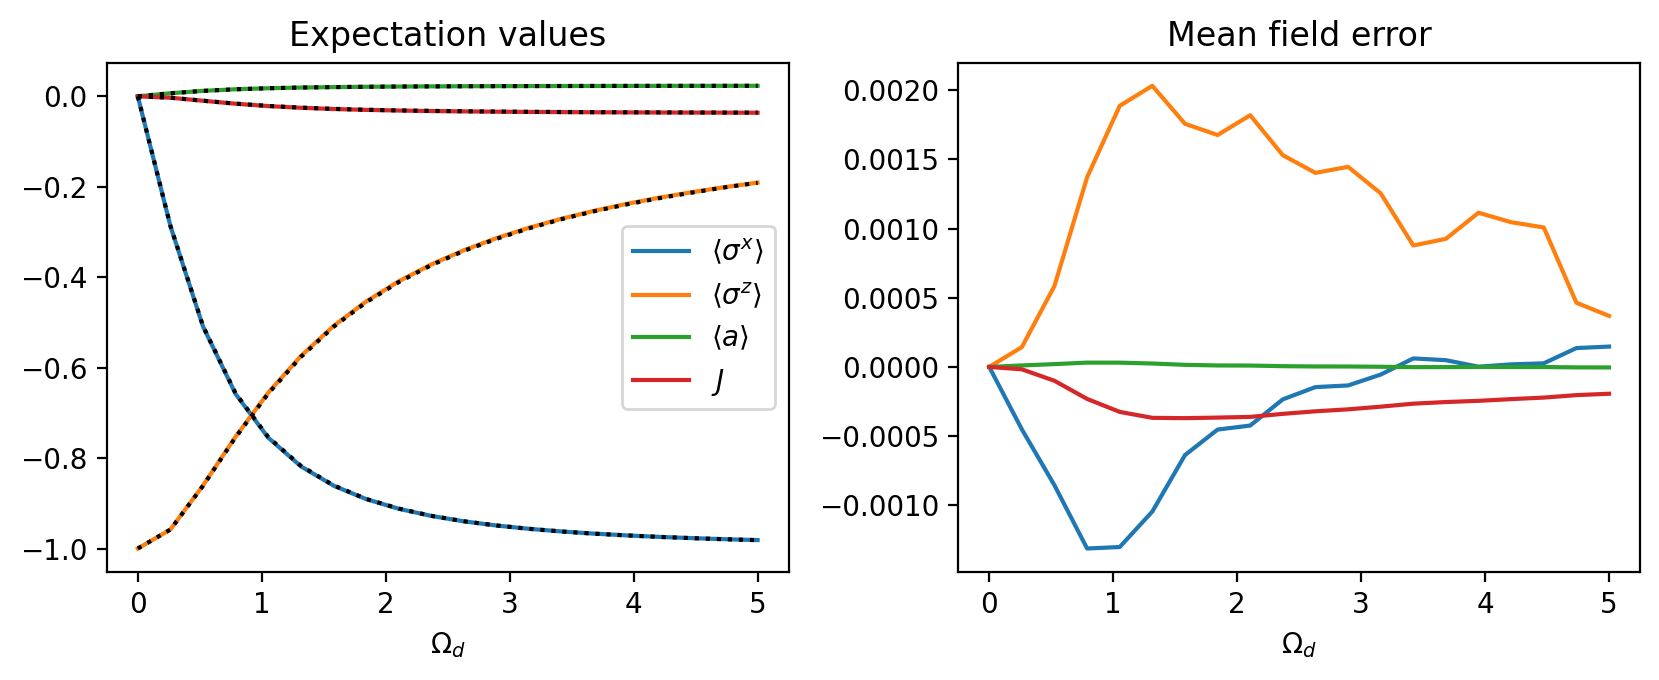

In [196]:
fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=np.array([12,5])*0.7, dpi=200)

ax1.plot(Ω_d_values, np.real(expectation_values_num), label=labels_expectation_values)
ax1.plot(Ω_d_values, np.real(expectation_values_MF),':k')
ax1.set_xlabel(r'$\Omega_d$')
ax1.legend()
ax1.set_title('Expectation values')

ax2.plot(Ω_d_values, np.real(expectation_values_num)-np.real(expectation_values_MF), label=labels_expectation_values)
ax2.set_xlabel(r'$\Omega_d$')
ax2.set_title('Mean field error')

fig.tight_layout()

#### $\Delta_q$

In [197]:
L, Nmax, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, theta_twist = params_0
Δ_q_values = np.geomspace(1e-4,2,100)
expectation_values_num = np.zeros([len(Δ_q_values), 4], dtype='complex')
expectation_values_MF  = np.zeros([len(Δ_q_values), 4], dtype='complex')

for i, Δ_q in enumerate(Δ_q_values):
    H, J = build_H_driven(L, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, Nmax,
                   boundary=boundary, theta_twist=theta_twist, return_J=True)
    local_ops, d = build_local_ops(L, Nmax)
    E0, psi0 = ground_state(H)
    s, α, mz = measure_order_params(psi0, local_ops)
    J_ED = expect(psi0, J).real
    expectation_values_num[i] = [s.mean()+s.conj().mean(), mz.mean(), α.mean(), -J_ED ]
    
    res = mf_order_params(Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ)
    expectation_values_MF[i] = [res["s"]+res["s"].conj(), res["m"], res["alpha"], res["J"]]

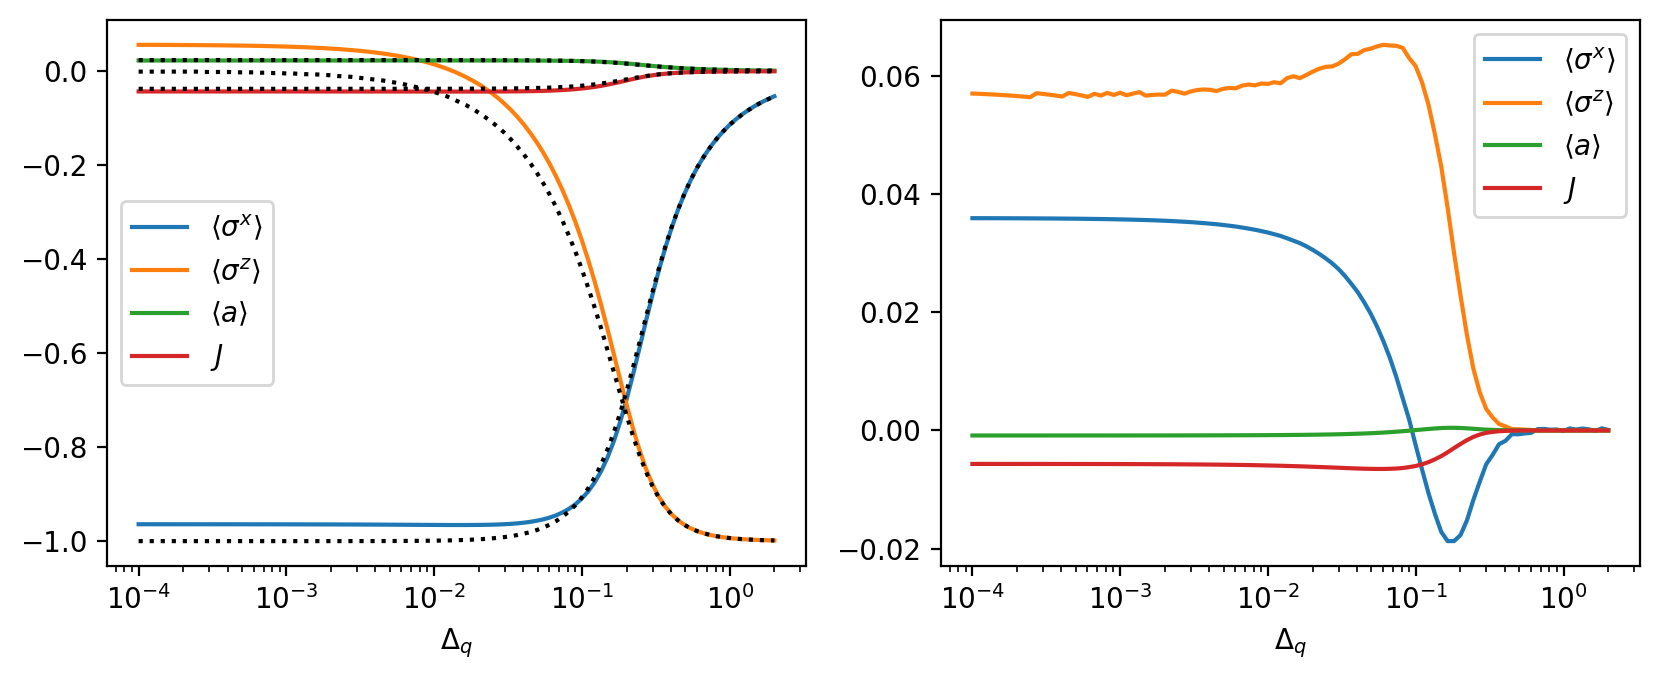

In [201]:
fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=np.array([12,5])*0.7, dpi=200)

ax1.plot(Δ_q_values, np.real(expectation_values_num), label=labels_expectation_values)
ax1.plot(Δ_q_values, np.real(expectation_values_MF),':k')
ax1.set_xlabel(r'$\Delta_q$')
ax1.legend()

ax2.plot(Δ_q_values, np.real(expectation_values_num)-np.real(expectation_values_MF), label=labels_expectation_values)
ax2.set_xlabel(r'$\Delta_q$')
ax2.legend()

ax1.set_xscale('log')
ax2.set_xscale('log')

fig.tight_layout()

#### $\delta_\Phi$

In [204]:
L, Nmax, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, theta_twist = params_0
Ω_d=1
δΦ_values = np.linspace(0,np.pi,20)
expectation_values_num = np.zeros([len(δΦ_values), 4], dtype='complex')
expectation_values_MF  = np.zeros([len(δΦ_values), 4], dtype='complex')

for i, δΦ in enumerate(δΦ_values):
    H, J = build_H_driven(L, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, Nmax,
                   boundary=boundary, theta_twist=theta_twist, return_J=True)
    local_ops, d = build_local_ops(L, Nmax)
    E0, psi0 = ground_state(H)
    s, α, mz = measure_order_params(psi0, local_ops)
    J_ED = expect(psi0, J).real
    expectation_values_num[i] = [s.mean()+s.conj().mean(), mz.mean(), α.mean(), -J_ED ]
    
    res = mf_order_params(Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ)
    expectation_values_MF[i] = [res["s"]+res["s"].conj(), res["m"], res["alpha"], res["J"]]

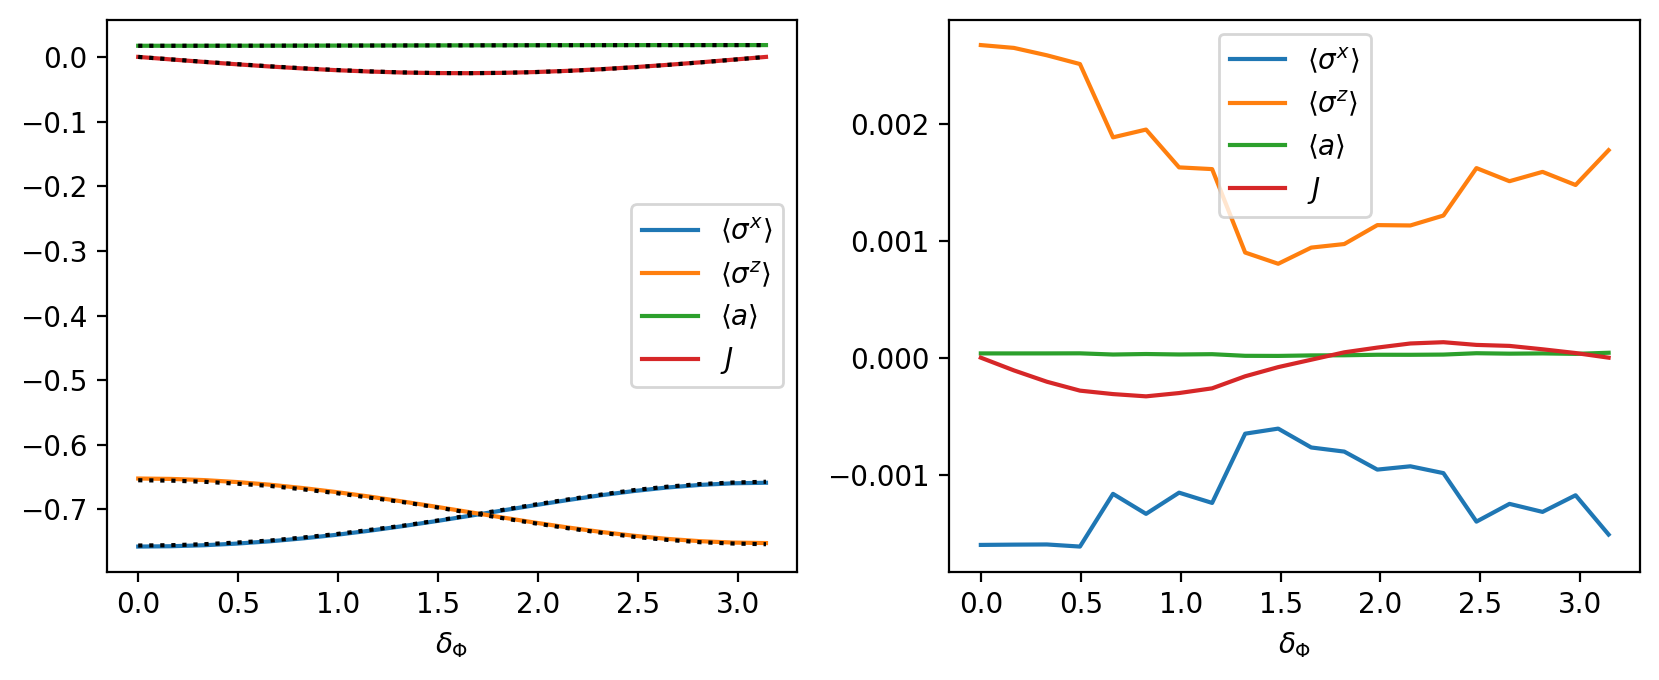

In [205]:
fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=np.array([12,5])*0.7, dpi=200)

ax1.plot(δΦ_values, np.real(expectation_values_num), label=labels_expectation_values)
ax1.plot(δΦ_values, np.real(expectation_values_MF),':k')
ax1.set_xlabel(r'$\delta_\Phi$')
ax1.legend()

ax2.plot(δΦ_values, np.real(expectation_values_num)-np.real(expectation_values_MF), label=labels_expectation_values)
ax2.set_xlabel(r'$\delta_\Phi$')
ax2.legend()

fig.tight_layout()

In [208]:
def ground_state_tracked(H, prev_state=None, prev_energy=None,
                         k=4, which="SA", tol=1e-10, maxiter=None,
                         use_shift=False):
    """
    Return (E, psi) for the ground state, chosen by largest overlap with prev_state if provided.

    Args:
        H : Hermitian sparse matrix.
        prev_state : complex ndarray or None. If given, we pick the eigenvector with max overlap.
        prev_energy: float or None. If use_shift=True, target eigenvalues near this sigma.
        k : number of eigenpairs to compute (>=2 recommended when tracking).
        which : 'SA' (smallest algebraic) by default.
        tol, maxiter : eigsh controls.
        use_shift : if True and prev_energy given, run shift-invert around sigma=prev_energy.

    Notes:
        - For small Hilbert spaces, you can set k=H.shape[0]-1 (dense-like) if desired.
        - Make sure H is Hermitian: (H - H.getH()).nnz == 0 up to numerical noise.
    """
    # Normalize seed for faster/more stable convergence
    v0 = None
    if prev_state is not None:
        nrm = np.linalg.norm(prev_state)
        if nrm > 0:
            v0 = (prev_state / nrm).astype(complex)

    # eigsh mode
    kwargs = dict(k=k, which=which, tol=tol, maxiter=maxiter, v0=v0)
    if use_shift and (prev_energy is not None):
        kwargs.update(dict(sigma=prev_energy, which="LM"))  # target eigenvalues near sigma

    evals, evecs = spla.eigsh(H, **kwargs)

    # Sort by energy just to be safe
    order = np.argsort(evals.real)
    evals = evals[order].real
    evecs = evecs[:, order]

    if prev_state is None:
        # First call: pick the lowest-energy vector
        idx = 0
    else:
        # Pick the vector with largest |overlap|
        overlaps = np.abs(evecs.conj().T @ prev_state)
        idx = int(np.argmax(overlaps))

    psi = evecs[:, idx]

    # Align global phase with prev_state for smoothness
    if prev_state is not None:
        ov = np.vdot(prev_state, psi)
        if ov != 0:
            psi = psi * np.exp(-1j * np.angle(ov))

    E = float(evals[idx])
    return E, psi


#### $g_q$

In [211]:
L, Nmax, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, theta_twist = params_0
g_q_values = np.linspace(0,0.7,20)
expectation_values_num = np.zeros([len(g_q_values), 4], dtype='complex')
expectation_values_MF  = np.zeros([len(g_q_values), 4], dtype='complex')
K_vs_g_q = np.zeros(len(g_q_values))

for i, g in enumerate(g_q_values):
    g_q = g
    H, J = build_H_driven(L, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, Nmax,
                   boundary=boundary, theta_twist=theta_twist, return_J=True)
    local_ops, d = build_local_ops(L, Nmax)
    if i ==0:
        E0, psi0 = ground_state(H)
    else:
        E0, psi0 = ground_state_tracked(H, prev_state=psi0, prev_energy=E0,
                             k=4, which="SA", tol=1e-10, maxiter=None, use_shift=False)
    s, α, mz = measure_order_params(psi0, local_ops)
    J_ED = expect(psi0, J).real
    expectation_values_num[i] = [s.mean()+s.conj().mean(), mz.mean(), α.mean(), -J_ED ]
    
    res = mf_order_params(Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ)
    expectation_values_MF[i] = [res["s"]+res["s"].conj(), res["m"], res["alpha"], res["J"]]
    
    K_vs_g_q[i] = res["K"]

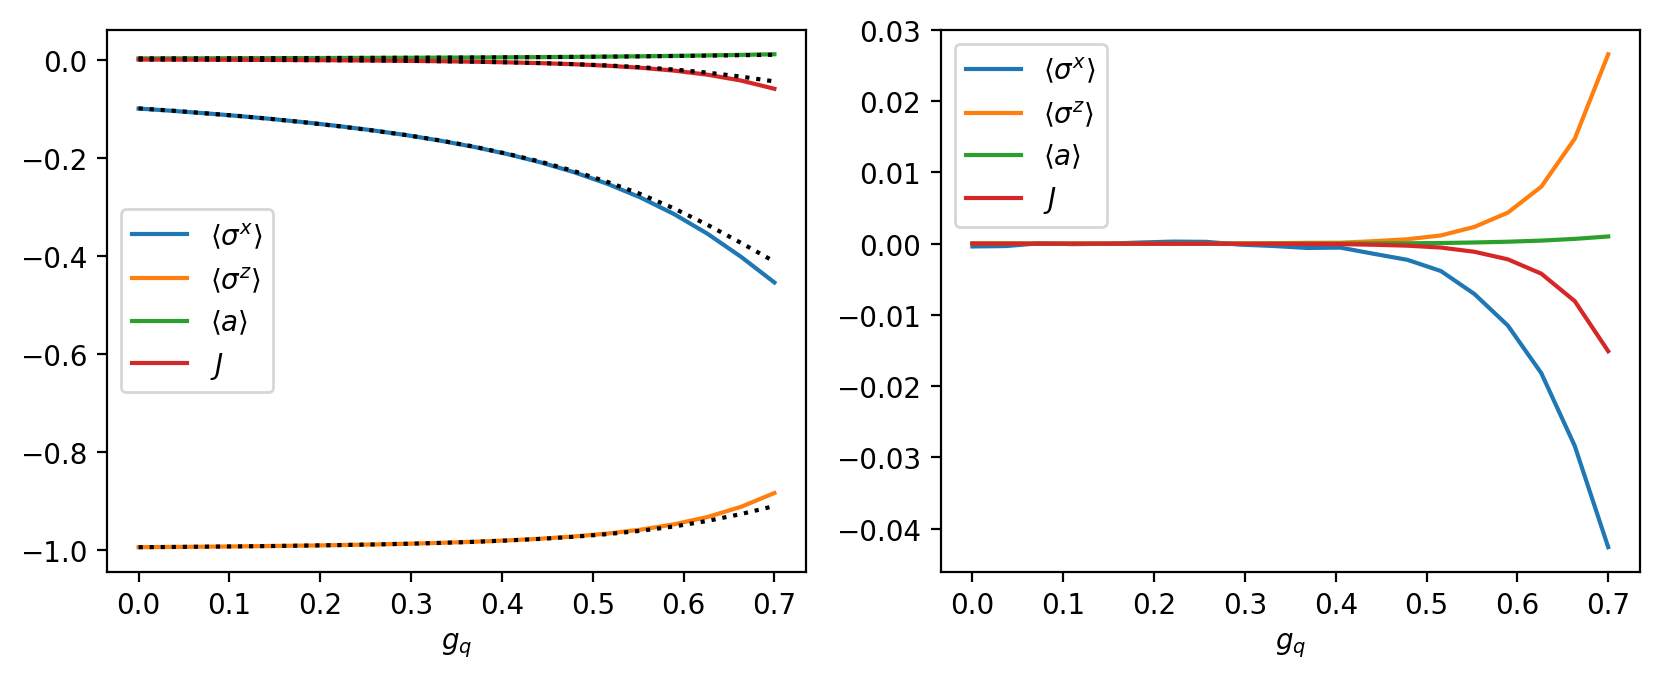

In [212]:
fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=np.array([12,5])*0.7, dpi=200)

ax1.plot(g_q_values, np.real(expectation_values_num), label=labels_expectation_values)
ax1.plot(g_q_values, np.real(expectation_values_MF),':k')
ax1.set_xlabel(r'$g_q$')
ax1.legend()

ax2.plot(g_q_values, np.real(expectation_values_num)-np.real(expectation_values_MF), label=labels_expectation_values)
ax2.set_xlabel(r'$g_q$')
ax2.legend()

# ax1.plot(g_q_values, K_vs_g_q/Δ_q)
# ax1.hlines(Δ_q,g_q_values[0],g_q_values[-1])
fig.tight_layout()

#### $g_\Phi$

In [179]:
L, Nmax, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, theta_twist = params_0
g_phi_values = np.linspace(0,3,100)
expectation_values_num = np.zeros([len(g_phi_values), 4], dtype='complex')
expectation_values_MF  = np.zeros([len(g_phi_values), 4], dtype='complex')

for i, g_phi in enumerate(g_phi_values):
    H, J = build_H_driven(L, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ, Nmax,
                   boundary=boundary, theta_twist=theta_twist, return_J=True)
    local_ops, d = build_local_ops(L, Nmax)
    E0, psi0 = ground_state(H)
    s, α, mz = measure_order_params(psi0, local_ops)
    J_ED = expect(psi0, J).real
    expectation_values_num[i] = [s.mean()+s.conj().mean(), mz.mean(), α.mean(), -J_ED ]
    
    res = mf_order_params(Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d, δΦ)
    expectation_values_MF[i] = [res["s"]+res["s"].conj(), res["m"], res["alpha"], res["J"]]

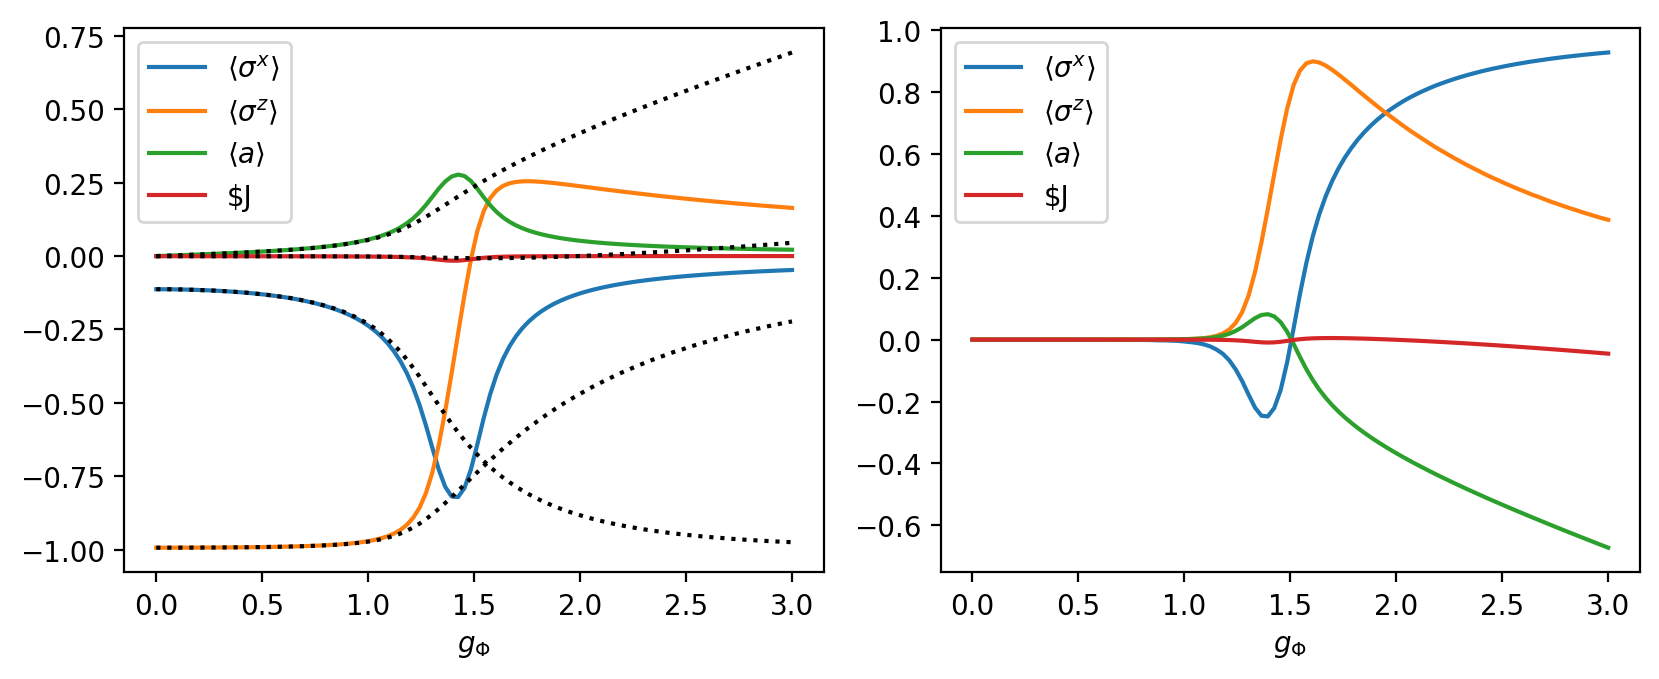

In [180]:
fig, [ax1,ax2] = plt.subplots(ncols=2, figsize=np.array([12,5])*0.7, dpi=200)

ax1.plot(g_phi_values, np.real(expectation_values_num), label=labels_expectation_values)
ax1.plot(g_phi_values, np.real(expectation_values_MF),':k')
ax1.set_xlabel(r'$g_\Phi$')
ax1.legend()

ax2.plot(g_phi_values, np.real(expectation_values_num)-np.real(expectation_values_MF), label=labels_expectation_values)
ax2.set_xlabel(r'$g_\Phi$')
ax2.legend()

fig.tight_layout()

## Zak phase

In [228]:
def precompute_berry_parts(L, Delta_q, Delta_c, g_phi, g_q, g_c, Omega_d, Nmax):
    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    D = d**L

    H_onsite = sp.csr_matrix((D, D), dtype=complex)
    for n in range(L):
        H_onsite += (Delta_q/2) * embed_one(ops['Sz'], n, L, d)
        H_onsite += (Omega_d/2) * embed_one(ops['Sx'], n, L, d)
        H_onsite +=  Delta_c    * embed_one(ops['Nb'], n, L, d)
        H_onsite +=  g_phi      * embed_one(ops['Sp'] @ ops['A'],  n, L, d)
        H_onsite +=  g_phi      * embed_one(ops['Sm'] @ ops['Ad'], n, L, d)

    g_qc = np.sqrt(g_q * g_c)
    T = sp.csr_matrix((D, D), dtype=complex)
    for n in range(L):
        i, j = n, (n + 1) % L
        T += (
            - g_q  * embed_two(ops['Sm'], i, ops['Sp'], j, L, d)
            + g_c  * embed_two(ops['A'],  i, ops['Ad'], j, L, d)
            - g_qc * ( embed_two(ops['Sm'], i, ops['Ad'], j, L, d) )
            + g_qc * ( embed_two(ops['A'],  i, ops['Sp'], j, L, d) )
        )

    Tdag = T.getH()
    H_c = (T + Tdag).tocsr()
    H_s = (1j * (T - Tdag)).tocsr()  # Hermitian

    return H_onsite, H_c, H_s

def H_with_twist(H_onsite, H_c, H_s, delta_phi, theta, L):
    phi = delta_phi + theta / L
    return H_onsite + np.cos(phi) * H_c + np.sin(phi) * H_s

def ground_state_tracked(H, prev_state=None, k=2, ncv=20, tol=1e-9, maxiter=None):
    v0 = None
    if prev_state is not None:
        nrm = np.linalg.norm(prev_state)
        if nrm > 0:
            v0 = (prev_state / nrm).astype(complex)
    evals, evecs = spla.eigsh(H, k=k, which="SA", v0=v0, ncv=ncv, tol=tol, maxiter=maxiter)
    order = np.argsort(evals.real)
    evals, evecs = evals[order].real, evecs[:, order]
    if prev_state is None:
        idx = 0
    else:
        overlaps = np.abs(evecs.conj().T @ prev_state)
        idx = int(np.argmax(overlaps))
    psi = evecs[:, idx]
    if prev_state is not None:
        ov = np.vdot(prev_state, psi)
        if ov != 0:
            psi *= np.exp(-1j * np.angle(ov))
    return float(evals[idx]), psi

def zak_phase_berry(L, Delta_q, Delta_c, g_phi, g_q, g_c,
                         Omega_d, delta_phi, Nmax, M=40, k=2, ncv=20):
    H0, Hc, Hs = precompute_berry_parts(L, Delta_q, Delta_c, g_phi, g_q, g_c, Omega_d, Nmax)
    thetas = np.linspace(0.0, 2*np.pi, M+1)  # wrap included
    gamma = 0.0 + 0.0j

    # first point
    H = H_with_twist(H0, Hc, Hs, delta_phi, thetas[0], L)
    E_prev, psi_prev = ground_state_tracked(H, prev_state=None, k=k, ncv=ncv)

    # loop
    for j in range(M):
        H = H_with_twist(H0, Hc, Hs, delta_phi, thetas[j+1], L)
        E, psi = ground_state_tracked(H, prev_state=psi_prev, k=k, ncv=ncv)
        ov = np.vdot(psi_prev, psi)
        gamma += np.log(ov / np.abs(ov))
        psi_prev, E_prev = psi, E

    gamma_real = float(np.mod(np.imag(gamma) + np.pi, 2*np.pi) - np.pi)
    return gamma_real


In [234]:
L=5; Nmax=1
Δ_q=1; Δ_c=1.1
g_phi=0; g_q=2; g_c=2
Ω_d=1; δΦ=1

gamma = zak_phase_berry(L, Δ_q, Δ_c, g_phi, g_q, g_c,
                        Ω_d, δΦ, Nmax, M=40, k=2, ncv=20)
print("Zak phase (radians):", gamma, "   (≈π is topological)")


Zak phase (radians): 9.827373954163221e-06    (≈π is topological)


# Time evolution

In [35]:
L = 5
Nmax = 1

omega_q = 1
omega_c = 3
g_phi   = 0
g_q     = 1
g_c     = 1
delta = omega_c-omega_q

# time grid (units of 1/ coupling)
t_max = 100
T = 10000
t = np.linspace(0.0, t_max, T)

H = build_H_full(L, omega_q, omega_c, g_phi, g_q, g_c, Nmax)

a_left = left_edge_state(delta, g_c, L)
# same profile on boson and qubit components:
psi0 = make_edge_state(L, Nmax, a_left, b_profile=a_left)

In [36]:
# build psi0 from your profile
a_left = left_edge_state(delta, g_c, L)   # your function
psi0 = make_edge_state(L, Nmax, a_left, b_profile=a_left)

# evolve
states = evolve(H, psi0, t)

# corrected raw observables
nb, SZ, _ = measure_local_ops(L, Nmax, states)
p_qubit_exc = 0.5*(1.0 + SZ)              # per site, per time
P_edge_raw = nb[:, :3].sum(1) + p_qubit_exc[:, :3].sum(1)

# projected (RWA-like) observables
p1, P_edge_1, P_mid = project_to_single_excitation(states, L, Nmax, n_edge=2)
P_edge_conditional = P_edge_1 / np.maximum(p1, 1e-15)
P_mid_conditional = P_mid / np.maximum(p1, 1e-15)


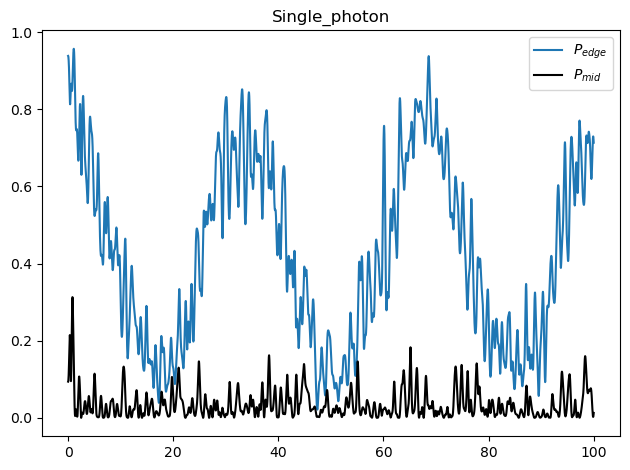

In [37]:
fig, ax = plt.subplots()

ax.plot(t, P_edge_conditional, label='$P_{edge}$')
ax.plot(t, P_mid_conditional,'k', label='$P_{mid}$')
ax.legend()
ax.set_title('Single_photon')
fig.tight_layout()

In [30]:
def edge_mid_probs_full(states, L, Nmax, n_edge=3):
    """
    Full-space analogue of project_to_single_excitation():
      states: array (T, D) of many-body states over time
    Returns:
      p_tot(t):  ⟨sum_n [P_e(n) + N_b(n)]⟩
      P_edge(t): ⟨sum_{n < n_edge} [P_e(n) + N_b(n)]⟩
      P_mid(t):  ⟨P_e(n_mid) + N_b(n_mid)⟩, with n_mid = L//2

    Notes:
      • If your evolution conserves total excitation number and you start in the 1-excitation sector,
        then p_tot(t) ≈ 1 and P_edge/P_mid are the same “where is the single excitation?” probabilities
        you were getting via the 1-excitation basis.
      • With drives or non-conserving terms, p_tot(t) is the expected excitation count (not a probability).
    """
    # local operators
    ops = cell_ops(Nmax)
    d   = ops['I'].shape[0]

    # Build sparse sums once: S_tot = Σn (P_e(n) + N_b(n)), S_edge = Σ_{n<n_edge}(...)
    def P_e(n):
        return 0.5 * (embed_one(ops['I'], n, L, d) + embed_one(ops['Sz'], n, L, d))
    def N_b(n):
        return embed_one(ops['Nb'], n, L, d)

    # totals
    S_tot  = None
    S_edge = None
    n_mid  = L // 2
    S_mid  = None

    for n in range(L):
        add_n = P_e(n) + N_b(n)
        S_tot  = add_n if S_tot  is None else (S_tot  + add_n)
        if n < n_edge:
            S_edge = add_n if S_edge is None else (S_edge + add_n)
        if n == n_mid:
            S_mid = add_n

    # Expectation over time
    T = states.shape[0]
    p_tot  = np.empty(T, dtype=float)
    P_edge = np.empty(T, dtype=float)
    P_mid  = np.empty(T, dtype=float)

    for t in range(T):
        psi = states[t]
        p_tot[t]  = np.real(expect(psi, S_tot))
        P_edge[t] = np.real(expect(psi, S_edge))
        P_mid[t]  = np.real(expect(psi, S_mid))

    return p_tot, P_edge, P_mid


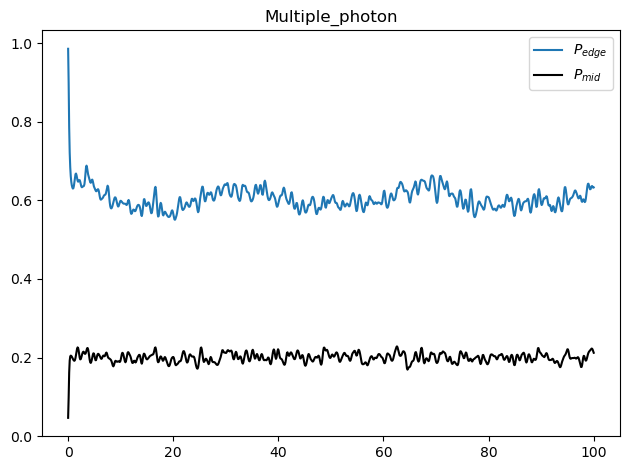

In [31]:
p1, P_edge_1, P_mid = edge_mid_probs_full(states, L, Nmax, n_edge=3)
P_edge_conditional = P_edge_1 / np.maximum(p1, 1e-15)
P_mid_conditional = P_mid / np.maximum(p1, 1e-15)

fig, ax = plt.subplots()
ax.plot(t, P_edge_conditional, label='$P_{edge}$')
ax.plot(t, P_mid_conditional,'k', label='$P_{mid}$')
ax.legend()
ax.set_title('Multiple_photon')
fig.tight_layout()

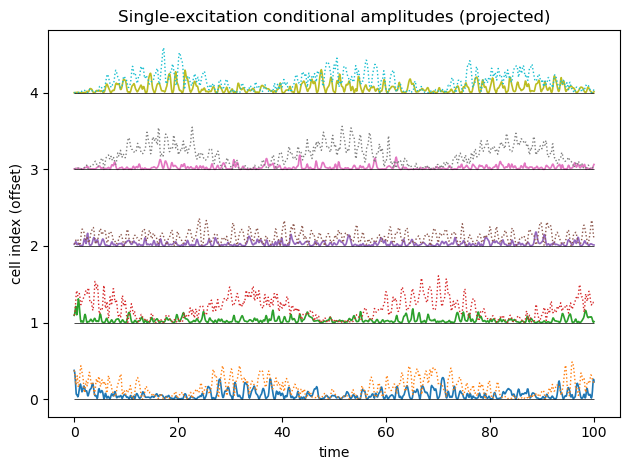

In [110]:
# assumes you already have: states (T x D), L, Nmax, t

# build 1-excitation basis and project
Phi, labels = single_excitation_basis(L, Nmax)   # from earlier reply
C = states @ Phi                                  # shape (T, 2L)

# split into a/b components
T = C.shape[0]
p_a1 = np.zeros((T, L))
p_b1 = np.zeros((T, L))
for k, (which, n) in enumerate(labels):
    if which == 'a':
        p_a1[:, n] = np.abs(C[:, k])**2
    else:  # 'b'
        p_b1[:, n] = np.abs(C[:, k])**2

# total weight in the single-excitation manifold
p1 = (p_a1.sum(axis=1) + p_b1.sum(axis=1))

# conditional probabilities (highlight transfer, factor out leakage)
eps = 1e-10
mask = p1 > 1e-6                      # avoid noisy division when almost no weight remains
pa_cond = np.full_like(p_a1, np.nan)  # NaN gaps when p1 is tiny
pb_cond = np.full_like(p_b1, np.nan)
pa_cond[mask] = (p_a1[mask].T / p1[mask]).T
pb_cond[mask] = (p_b1[mask].T / p1[mask]).T

# plot like your original: solid for a_n, dotted for b_n with vertical offsets
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(L):
    ax.plot(t, pa_cond[:, i] + i, lw=1.2)
    ax.plot(t, pb_cond[:, i] + i, ':', lw=1.0)
    ax.hlines(i, t[0], t[-1], linewidth=0.5, color='k')
ax.set_xlabel('time')
ax.set_ylabel('cell index (offset)')
ax.set_title('Single-excitation conditional amplitudes (projected)')
fig.tight_layout()


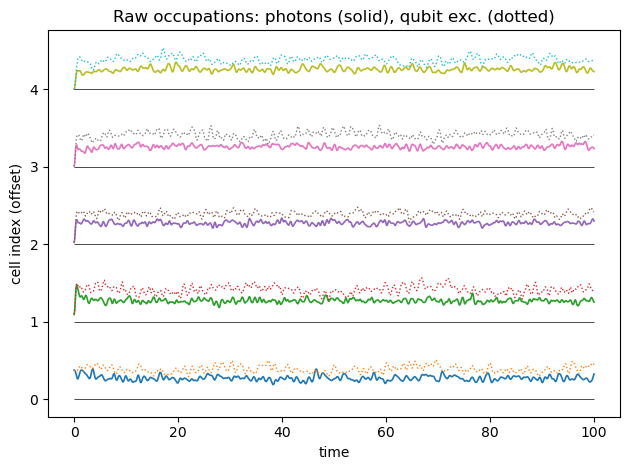

In [111]:
# from earlier: nb(t,i) = <a_i† a_i>, sz(t,i) = <σ^z_i>
p_e = 0.5 * (1.0 + sz)   # excitation probability of qubit i

fig, ax = plt.subplots()
for i in range(L):
    ax.plot(t, nb[:, i] + i, lw=1.2)
    ax.plot(t, p_e[:, i] + i, ':', lw=1.0)
    ax.hlines(i, t[0], t[-1], linewidth=0.5, color='k')
ax.set_xlabel('time')
ax.set_ylabel('cell index (offset)')
ax.set_title('Raw occupations: photons (solid), qubit exc. (dotted)')
fig.tight_layout()


## Spectroscopy with time evolution and perturbation to first qubit

In [70]:
def _local_drive_op(L, Nmax, j_drive=0):
    """Ω/2·cos(ωt)·Sx on qubit j_drive."""
    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    return embed_one(ops['Sx'], j_drive, L, d)

def _qubit_excitation_op(L, Nmax, j=0):
    """Projector onto |e> on qubit j assuming σz|g>=- |g>, σz|e>=+ |e|."""
    ops = cell_ops(Nmax)
    d = ops['I'].shape[0]
    return 0.5 * (embed_one(ops['I'], j, L, d) + embed_one(ops['Sz'], j, L, d))
    # If you don't have 'Iq' in ops, replace ops['Iq'] by ops['Iq'] -> ops['Iq'] exists in your build_local_ops.
    # Alternatively: 0.5*(embed_one(ops['Iq'], j, L, d) + embed_one(ops['Sz'], j, L, d))

def evolve_drive_time_sweep_full(
    L, Δ_q, Δ_c, g_phi, g_q, g_c, δΦ=0.0, Nmax=1, boundary="open",
    j_drive=0, Omega=0.02, omega_list=None,
    gamma=1e-3, T_trans=400.0, T_avg=200.0, points_per_unit=50
):
    """
    Frequency sweep with a local, time-dependent drive on qubit j_drive:
        H(t) = H0  +  (Omega/2)*cos(ω t)*D
    using your many-body ops and your evolve() for piecewise-constant steps.

    Returns: omegas (array), response (array) where response = time-avg ⟨P_e(j_drive)⟩.
    """
    # 0) Static many-body Hamiltonian (use your driven *structure*, but set Ω_d=0 here)
    H0 = build_H_driven(L, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d=0.0, δΦ=δΦ, Nmax=Nmax, boundary=boundary)

    # optional non-Hermitian damping to reach steady-state
    if gamma and gamma > 0:
        H0 = H0 - 1j*(gamma/2.0) * (sp.eye(H0.shape[0], format='csr', dtype=complex) if sp.issparse(H0) else np.eye(H0.shape[0], dtype=complex))

    # 1) Local drive operator and observable
    D  = _local_drive_op(L, Nmax, j_drive=j_drive)
    Pe = _qubit_excitation_op(L, Nmax, j=j_drive)

    # 2) Initial state (your vacuum)
    psi = vacuum_state(L, Nmax).astype(complex)

    # 3) Frequency grid
    if omega_list is None:
        # crude auto-window from H0 spectrum (optional, can pass your own)
        try:
            # small dense block via eigsh on sparse if large
            if sp.issparse(H0):
                from scipy.sparse.linalg import eigsh
                ev = eigsh(H0, k=min(16, H0.shape[0]-2), which='SM', return_eigenvectors=False)
            else:
                ev = np.linalg.eigvalsh(H0)
            wmin, wmax = np.min(ev.real), np.max(ev.real)
            span = max(1e-2, wmax - wmin)
            omega_list = np.linspace(wmin - 0.15*span, wmax + 0.15*span, 300)
        except Exception:
            omega_list = np.linspace(-2.0, 2.0, 300)

    responses = np.empty_like(omega_list, dtype=float)

    # 4) Sweep
    for i, ω in enumerate(omega_list):
        print(i/len(omega_list) * 100)
        # time grid: choose dt so we resolve the carrier: points_per_unit per 2π period
        dt = (2*np.pi) / (points_per_unit * max(1e-6, abs(ω)))
        if not np.isfinite(dt) or dt > 0.2:  # when ω≈0 make dt modest
            dt = 0.05
        T_total = T_trans + T_avg
        steps   = int(np.ceil(T_total / dt))
        t0      = 0.0

        psi_t = psi.copy()
        acc = 0.0
        n_samp = 0

        for k in range(steps):
            t = t0 + k*dt
            # piecewise-constant Hamiltonian
            Ht = H0 + 0.5*Omega*np.cos(ω*t) * D
            # propagate one step with your time-independent evolve()
            Y = evolve(Ht, psi_t, np.array([t, t+dt]))  # returns array of states at those times
            psi_t = Y[-1]

            if t >= T_trans:
                # accumulate observable
                # expect() is yours: ⟨psi|O|psi⟩
                acc += expect(psi_t, Pe)
                n_samp += 1

        responses[i] = (acc / max(1, n_samp)).real

    return omega_list, responses

In [71]:

L, Nmax = 3, 1
pars = dict(Δ_q=-0.1, Δ_c=0.1, g_phi=0, g_q=1, g_c=1, δΦ=0.0, boundary="open")

H0 = build_H_driven(L, Δ_q, Δ_c, g_phi, g_q, g_c, Ω_d=0.0, δΦ=δΦ, Nmax=Nmax, boundary=boundary)
E = spla.eigsh(H0, k=H0.shape[0]-2)[0]

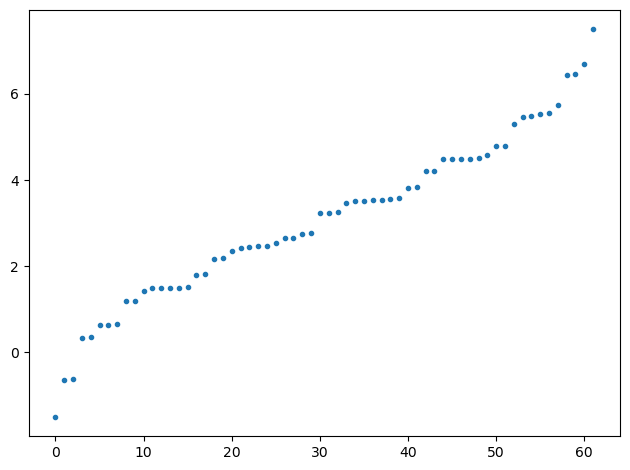

In [72]:
fig, ax = plt.subplots()

ax.plot(np.sort(E),'.')

fig.tight_layout()

In [73]:
omega_list = np.linspace(-3,10,100)

T_trans=100
T_avg=100
points_per_unit=8

omegas, R = evolve_drive_time_sweep_full(L=L, Nmax=Nmax, j_drive=0, Omega=0.02,omega_list=omega_list,T_trans=T_trans,T_avg=T_avg,points_per_unit=points_per_unit, **pars)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.000000000000001
8.0
9.0
10.0
11.0
12.0
13.0
14.000000000000002
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.000000000000004
28.999999999999996
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.00000000000001
56.00000000000001
56.99999999999999
57.99999999999999
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0


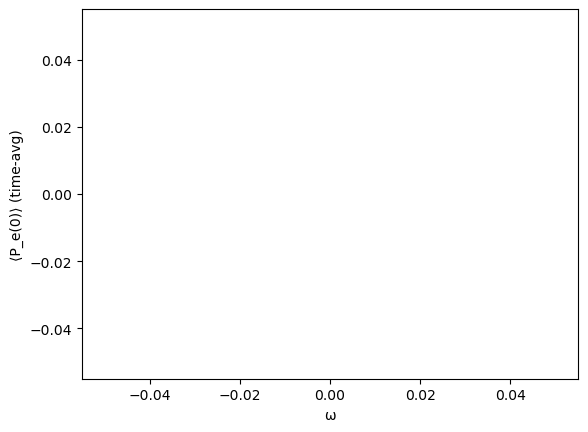

In [74]:

plt.plot(omegas, R); plt.xlabel("ω"); plt.ylabel("⟨P_e(0)⟩ (time-avg)"); plt.show()


In [76]:
R

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])